# SSD Training

In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd_custom import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

Using TensorFlow backend.


## Set the model configuration parameters

In [2]:
img_height = 300
img_width = 480
img_channels = 3
intensity_mean = 127.5
intensity_range = 127.5
n_classes = 5
scales = None
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

## Build the model

In [3]:
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)





Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


## Set up the data generators for the training

In [4]:
# Instantiate two `DataGenerator` objects: One for training, one for validation, loading the images into memory.

train_dataset.create_hdf5_dataset(file_path='C:/Users/Ignatios/Documents/ssd_keras/hdf5_datasets/dataset_train.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='C:/Users/Ignatios/Documents/ssd_keras/hdf5_datasets/dataset_val.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='C:/Users/Ignatios/Documents/ssd_keras/hdf5_datasets/dataset_train.h5')
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='C:/Users/Ignatios/Documents/ssd_keras/hdf5_datasets/dataset_val.h5')

# Parse the image and label lists for the training and validation datasets.

images_dir = 'C:/Users/Ignatios/Documents/ssd_keras/images/'

train_labels_filename = 'C:/Users/Ignatios/Documents/ssd_keras/annotations/train_labels.csv'
val_labels_filename   = 'C:/Users/Ignatios/Documents/ssd_keras/annotations/validation_labels.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'],
                      include_classes='all')

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 77/77 [00:00<00:00, 5136.81it/s]
Number of images in the training dataset:	   614
Number of images in the validation dataset:	    77


In [5]:
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels

# Set the batch size.
batch_size = 16

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# Define the image processing chain.

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain,
                                                      resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

## Set the model callbacks

In [6]:
model_checkpoint = ModelCheckpoint(filepath='C:/Users/Ignatios/Documents/ssd_keras/model_weights/custom/ssd6_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd6_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=6,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

## Train the model

We first trained the model for 20 epochs

In [7]:
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 500

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/20





500/500 [==============================] - 2552s 5s/step - loss: 4.8977 - val_loss: 4.1989
Epoch 2/20
500/500 [==============================] - 2505s 5s/step - loss: 3.7691 - val_loss: 3.6197
Epoch 3/20
500/500 [==============================] - 2514s 5s/step - loss: 3.4407 - val_loss: 3.2433
Epoch 4/20
500/500 [==============================] - 2517s 5s/step - loss: 3.2191 - val_loss: 2.9607
Epoch 5/20
500/500 [==============================] - 2505s 5s/step - loss: 3.0329 - val_loss: 2.9668
Epoch 6/20
500/500 [==============================] - 2507s 5s/step - loss: 2.9112 - val_loss: 2.6824
Epoch 7/20
500/500 [==============================] - 2519s 5s/step - loss: 2.8152 - val_loss: 2.6698
Epoch 8/20
500/500 [==============================] - 2486s 5s/step - loss: 2.7422 - val_loss: 2.5447
Epoch 9/20
500/500 [==============================] - 2506

A look at how the training and validation loss evolved:

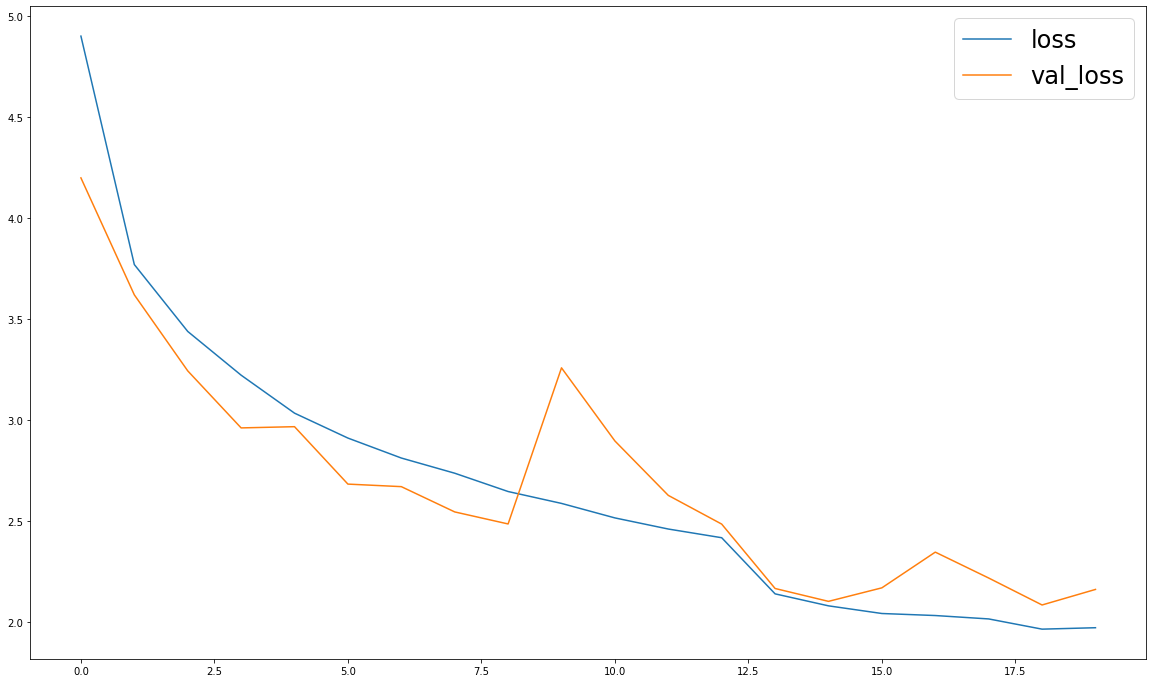

In [8]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});